# Consumer Complaints Data
Rev 10.2017 | Jay Phinizy

Original Data from: https://www.consumerfinance.gov/data-research/consumer-complaints/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from textblob import TextBlob
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter



### Import DataFrame, filter by Capital One complaints.

In [3]:
def csvToDF(fn):
    """
    Import the Consumer Complaints data found here:
    https://www.consumerfinance.gov/data-research/consumer-complaints/
    :param fn: File Name to be imported (csv)
    :return: Consumer Complaints DataFrame ready for analysis
    """
    df = pd.read_csv(fn,
                     parse_dates=['Date sent to company', 'Date received'],
                     infer_datetime_format=1,
                     true_values=['Yes', 'Consent provided'],
                     false_values=['No', 'Consent not provided'])
    df.set_index('Complaint ID', inplace=True)
    print('.csv to DataFrame import complete.')
    c1df = df[df.Company == 'CAPITAL ONE FINANCIAL CORPORATION']
    print('Filter by Capital One complete.')
    return(c1df)

df = csvToDF('Consumer_Complaints.csv')
print('df is now loaded with Capital One complaints.')

.csv to DataFrame import complete.
Filter by Capital One complete.
df is now loaded with Capital One complaints.


### Append Polarity, Subjectivity, & Sentiment Categorical Classification to df

Consider NRC Emotion Lexicon: http://www.saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [4]:
def pol_calc(text):
    """
    Converts consumer complaint to a polarity measure using TextBlob
    :param text: Consumer complaint narrative
    :return: Polarity value (-1 -> 1)
    """
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df['pol'] = df['Consumer complaint narrative'].apply(pol_calc)
print('Polarity appended to df (pol)')


def sub_calc(text):
    """
    Converts consumer complaint to a subjectivity measure using TextBlob
    :param text: Consumer complaint narrative
    :return: Subjectivity value (-1 -> 1)
    """
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

df['sub'] = df['Consumer complaint narrative'].apply(sub_calc)
print('Subjectivity appended to df (sub)')

def cla_calc_man(text):
    """
    Converts polarity created by pol_calc to a hierarchical
    5-level sentiment classification
    :param text: Consumer complaint narrative
    :return: Sentiment classification (very negative, negative, neutral, positive, very positive)
    """
    try:
        if text < -.5:
           sentiment = "very negative"
        elif text >= -.5 and text < 0:
            sentiment = "negative"
        elif text == 0:
             sentiment = "neutral"
        elif text > 0 and text <= .5:
            sentiment = "positive"
        elif text > .5:
            sentiment = "very positive"
        else:
            sentiment = None
        return sentiment
    except:
        return None

df['cla'] = df['pol'].apply(cla_calc_man)
print('Hierarchical 5-level classification complete (cla)')

Polarity appended to df (pol)
Subjectivity appended to df (sub)
Hierarchical 5-level classification complete (cla)


### Explicitly include "complaint" in consumer narratives, analyze

Since some complaints are descriptive and neutral in nature or may contain words
commonly associated with positivity, add "My complaint is: " to the start of complaints for
further analysis.

In [6]:
df['Modified consumer complaint narrative'] = np.where(df['Consumer complaint narrative'].notnull(),
                                                       'My complaint is: ' + df['Consumer complaint narrative'].astype(str), None)

Re-run sentiment analyses with modified complaints, creating polarity (mpol), subjectivity (msub), and classification (mcla)

In [7]:
df['mpol'] = df['Modified consumer complaint narrative'].apply(pol_calc)
print('mpol complete')
df['msub'] = df['Modified consumer complaint narrative'].apply(sub_calc)
print('msub complete')
df['mcla'] = df['mpol'].apply(cla_calc_man)
print('mcla complete')

mpol complete
msub complete
mcla complete


Calculate the difference in polarity between the new modified complaint narrative and the original.

In [8]:
df['poldiff'] = df.mpol-df.pol
print('poldiff complete')

poldiff complete


Binarize the company response to consumer so we can isolate customers who received monetary relief from those who did not.

In [9]:
df['rec_mon'] = np.where(df['Company response to consumer'] == 'Closed with monetary relief', 1, 0)

Get the wordcount of consumer complaint. We'll use this to assess the impact of the modified complaint narrative as well as determining if the length of a complaint impacts the likelihood of receiving monetary relief

In [10]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(str)
df['Consumer complaint narrative count'] = df['Consumer complaint narrative'].str.split(" ").apply(len)

Split complaints into words, use lower(), lemmatize(), singularize(), and correct(). Assign to new column.

In [134]:
df['Consumer complaint words'] = [TextBlob(t).correct().words.lower().lemmatize().singularize() for t in df['Consumer complaint narrative']]
print(df)

             Date received                  Product  \
Complaint ID                                          
486251          2013-08-10                 Mortgage   
43679           2012-04-05              Credit card   
1331806         2015-04-15              Credit card   
1740552         2016-01-14  Bank account or service   
493909          2013-08-16                 Mortgage   
2277131         2017-01-05              Credit card   
349856          2013-03-11                 Mortgage   
922989          2014-07-03          Debt collection   
189407          2012-11-12              Credit card   
2242815         2016-12-09              Credit card   
1940479         2016-05-25              Credit card   
2397110         2017-03-21              Credit card   
1759876         2016-01-27              Credit card   
820724          2014-04-23              Credit card   
1003742         2014-08-27  Bank account or service   
1154481         2014-12-12                 Mortgage   
1618314   

In [164]:
# WIP: compile full list of words used by people who received and didn't receive monetary compensation; count words and find most common.
rec_mon = np.where((df['rec_mon'] == 1)&(df['rec_mon'].notnull()), Counter(' '.join(df['Consumer complaint words'].values.tolist())).items(),None)
print(rec_mon)

TypeError: sequence item 0: expected str instance, WordList found

### General Data Exploration

#### Describe df

In [11]:
print('----- Info -----')
print(df.info())
print('----- Head -----')
print(df.head(20))
print('----- Describe -----')
print(df.describe())

----- Info -----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22659 entries, 486251 to 710260
Data columns (total 27 columns):
Date received                            22659 non-null datetime64[ns]
Product                                  22659 non-null object
Sub-product                              9371 non-null object
Issue                                    22659 non-null object
Sub-issue                                4905 non-null object
Consumer complaint narrative             22659 non-null object
Company public response                  0 non-null object
Company                                  22659 non-null object
State                                    22376 non-null object
ZIP code                                 22376 non-null object
Tags                                     3078 non-null object
Consumer consent provided?               7462 non-null object
Submitted via                            22659 non-null object
Date sent to company                     22659 no

In [12]:
# Number of complaints per product
print(df.groupby('Product')['Product'].count().head())

Product
Bank account or service         2445
Checking or savings account      244
Consumer Loan                   1212
Credit card                    12920
Credit card or prepaid card     1086
Name: Product, dtype: int64


In [22]:
    # Number of complaints per sub-product, grouped by product
    print(df.groupby(['Product','Sub-product']).count().head())

                                                            Date received  \
Product                 Sub-product                                         
Bank account or service (CD) Certificate of deposit                   120   
                        Cashing a check without an account              7   
                        Checking account                             1450   
                        Other bank product/service                    532   
                        Savings account                               336   

                                                            Issue  Sub-issue  \
Product                 Sub-product                                            
Bank account or service (CD) Certificate of deposit           120          0   
                        Cashing a check without an account      7          0   
                        Checking account                     1450          0   
                        Other bank product/service          

In [27]:
# Number of complaints by sentiment classification and whether monetary compensation was offered.
df_grp = df[['cla', 'rec_mon','Date received']]
print('Original Complaints')
print(df_grp.groupby(['cla', 'rec_mon']).count().head(10))


                       Date received
cla           rec_mon               
negative      0                 1692
              1                  154
neutral       0                  441
              1                   19
positive      0                 1774
              1                  175
very negative 0                    6
very positive 0                   10


In [30]:
# Number of complaints by modified sentiment classification and whether monetary compensation was offered.
df_grp2 = df[['mcla', 'rec_mon','Date received']]
print('Modified Complaints')
print(df_grp2.groupby(['mcla', 'rec_mon']).count().head(10))

Modified complaints
                       Date received
mcla          rec_mon               
negative      0                 2590
              1                  225
neutral       0                   11
positive      0                 1316
              1                  123
very negative 0                    6


#### Visualize the data

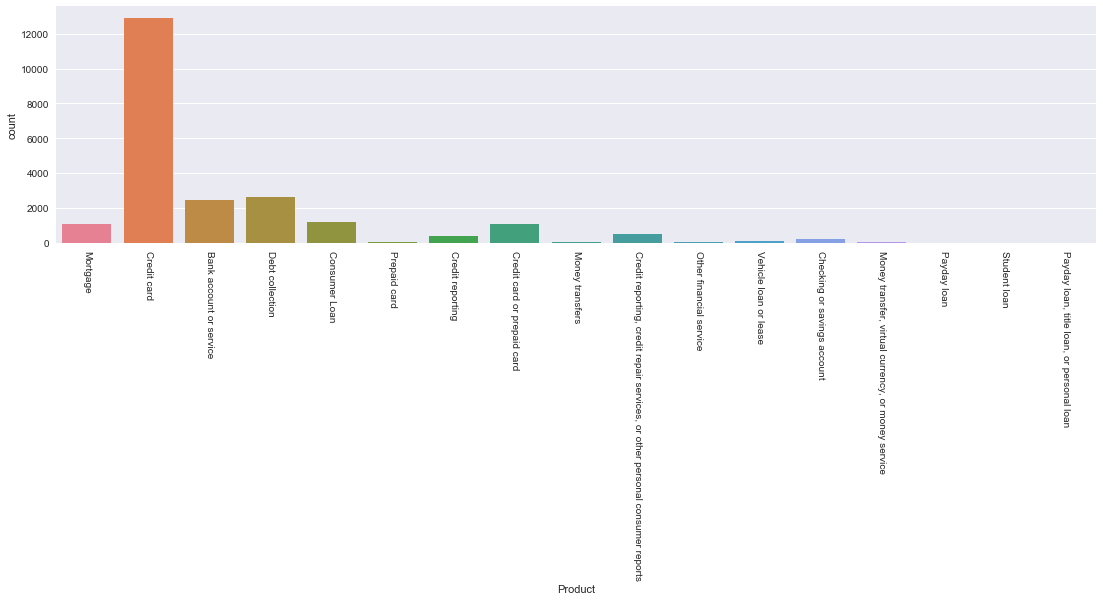

In [50]:
# Factor plot of products
fg = sns.factorplot('Product', data=df, kind='count', palette='husl', aspect=4)
fg.set_xlabels('Product')
fg.set_xticklabels(rotation=-90)

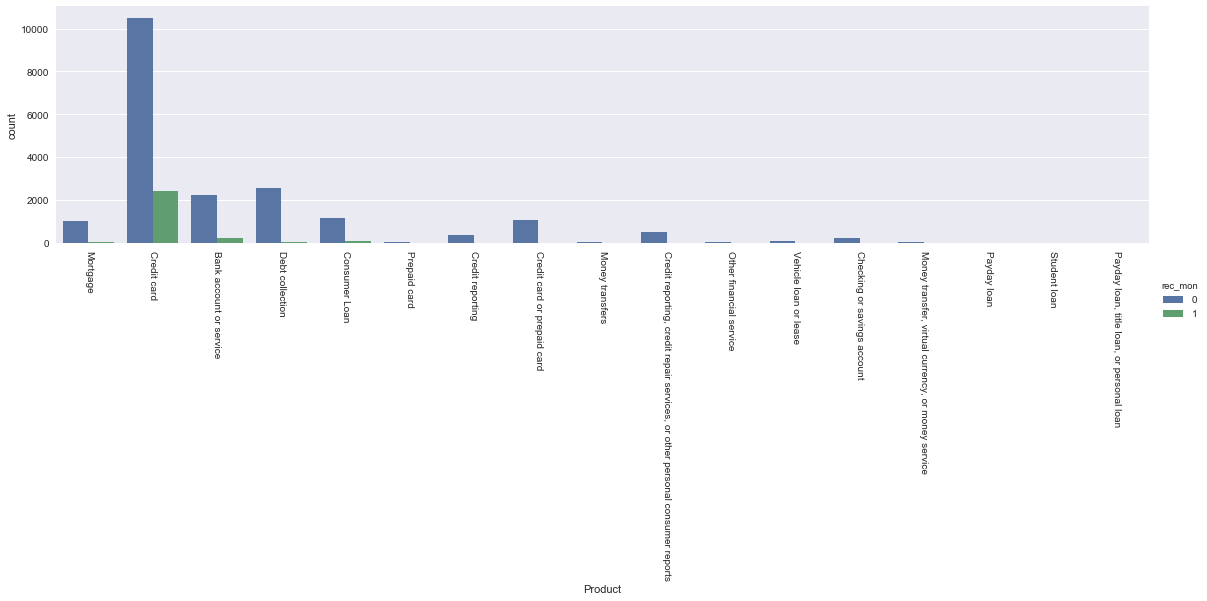

In [63]:
# Factor plot of products
fg = sns.factorplot('Product', data=df, kind='count', aspect=4, hue='rec_mon')
fg.set_xlabels('Product')
fg.set_xticklabels(rotation=-90)

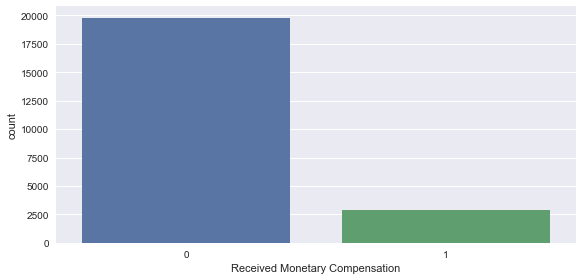

In [92]:
# Factor plot of timely response
fg = sns.factorplot('rec_mon', data=df, kind='count', aspect=2)
fg.set_xlabels('Received Monetary Compensation')

**Explore complaint counts by state.**

(Would be beneficial to scale by population.)

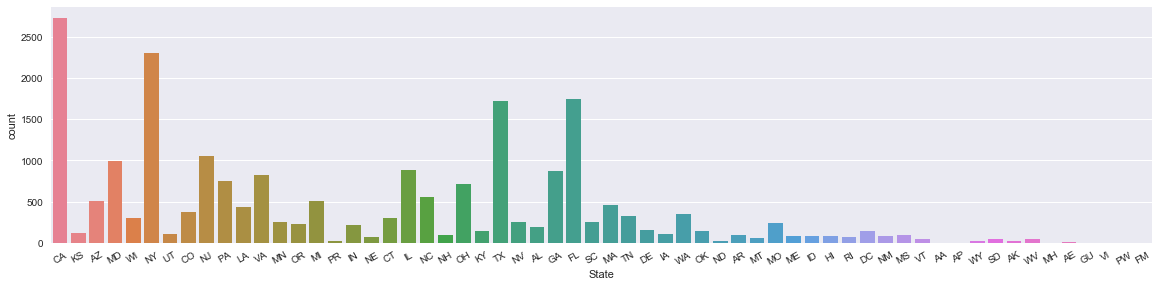

In [61]:
# Factor plot by state
fg = sns.factorplot('State', data=df, kind='count', palette='husl', aspect=4)
fg.set_xlabels('State')
fg.set_xticklabels(rotation=30)

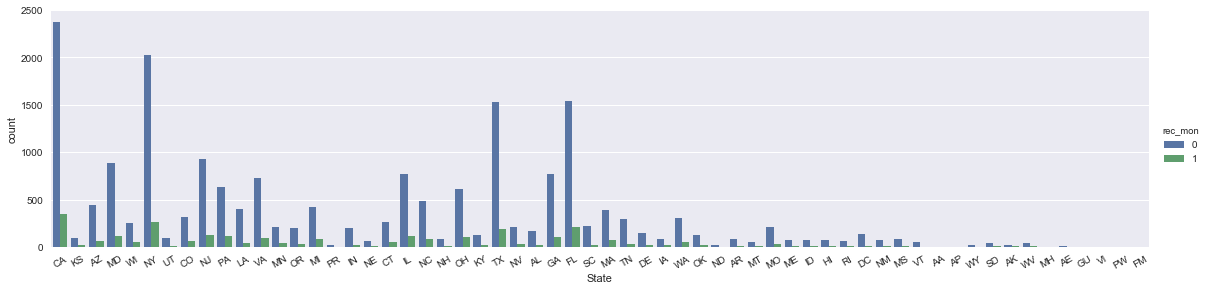

In [60]:
# Factor plot by state
fg = sns.factorplot('State', data=df, kind='count', aspect=4, hue='rec_mon')
fg.set_xlabels('State')
fg.set_xticklabels(rotation=30)

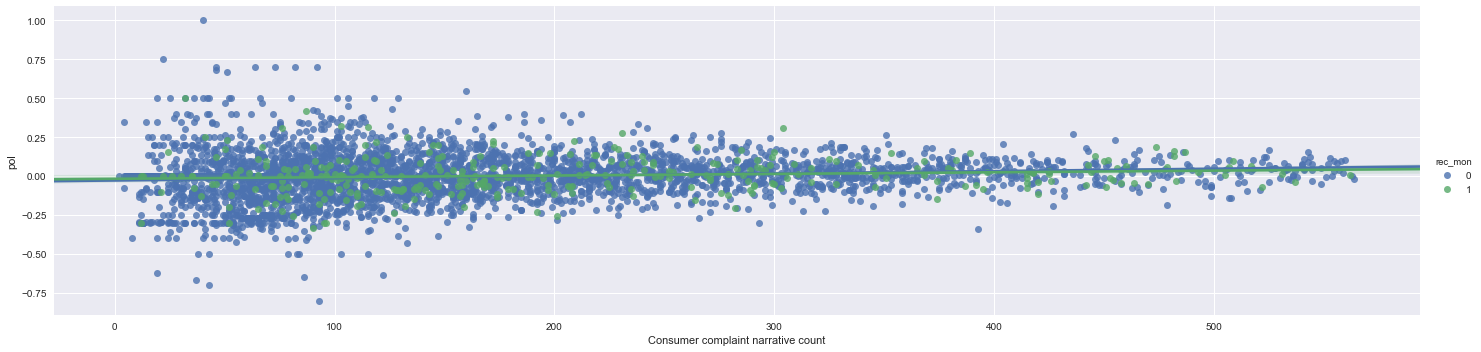

In [100]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]

sns.lmplot(x='Consumer complaint narrative count', y='pol', data=df_noout, hue='rec_mon', aspect=4)

Below, we'll repeat the plot, but with polarities based on modified customer complaints. The upward slope tells us that longer complaints were not as well balanced by our introductory "My complaint is:" text, which makes sense. Perhaps we would need to insert the phrase "complaint:" at the start of every sentence, but that could penalize the data in the opposite direction.

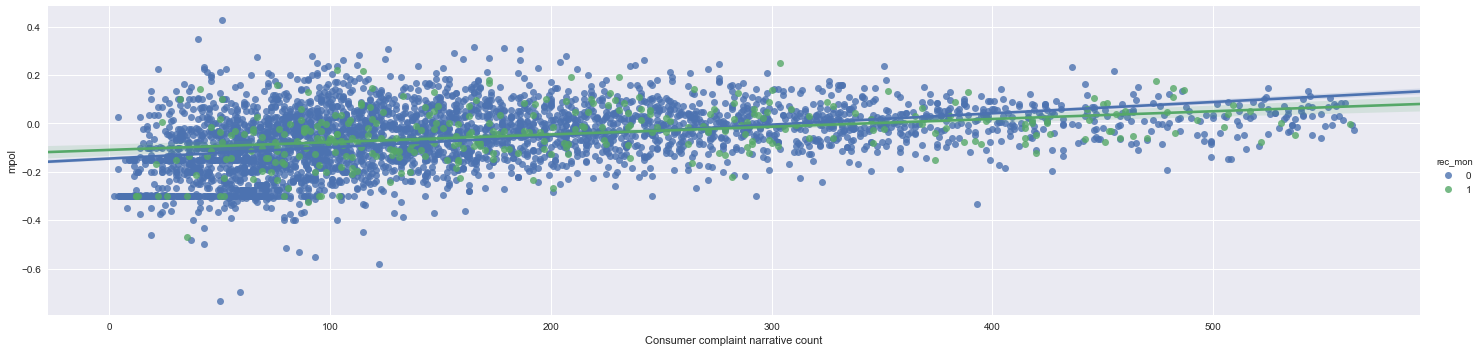

In [99]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]

sns.lmplot(x='Consumer complaint narrative count', y='mpol', data=df_noout, hue='rec_mon', aspect=4)

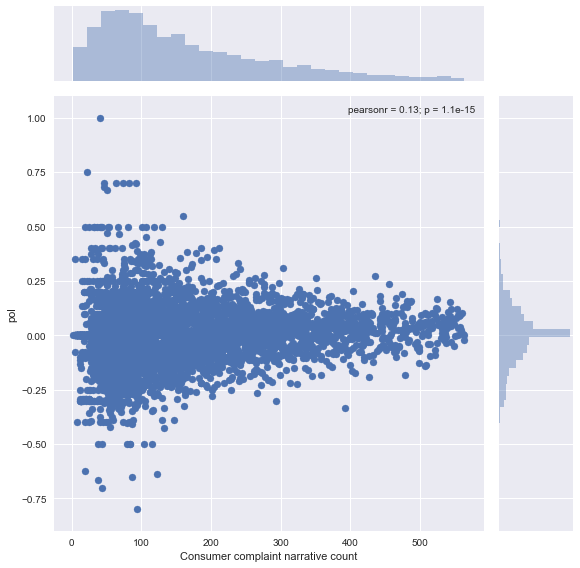

In [125]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]

sns.jointplot(x='Consumer complaint narrative count', y='pol', size=8, data=df_noout)

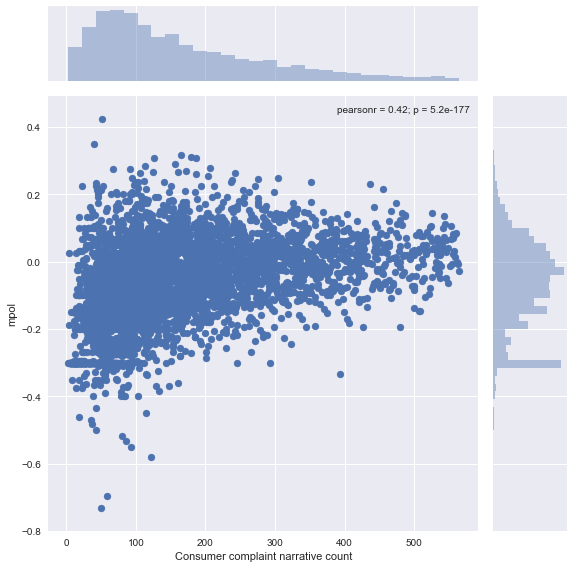

In [124]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]

sns.jointplot(x='Consumer complaint narrative count', y='mpol', size=8, data=df_noout)

The data appears to be more appropriately balanced with less positive and more negative polarities. That said, the distribution has become bimodal, with a second peak appearing at approximately -0.3. Let's see if this corresponds with the polarity of the modified customer complaint appended text:

In [115]:
print(pol_calc('My complaint is:'))

-0.3


And it does; we might hypothesize that these are complaints with very short lengths.

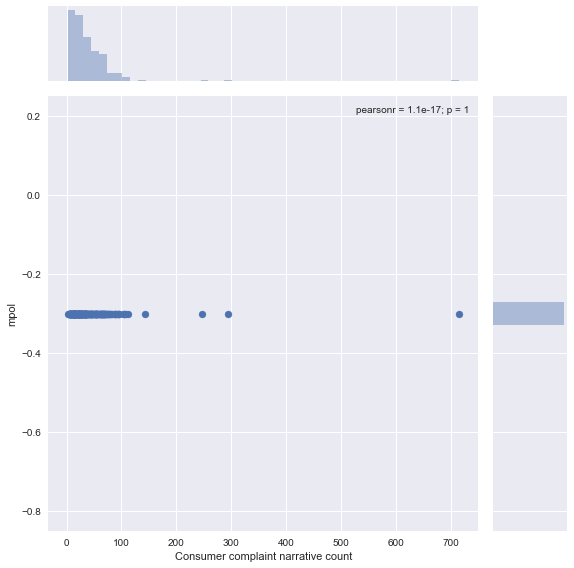

In [123]:
df_noout = df[df["mpol"] == -0.3]
sns.jointplot(x='Consumer complaint narrative count', y='mpol', size=8, data=df_noout)

We see that, in fact, the most -0.3 polarity complaints are very short. 

Let's look at the counts of complaints by product.

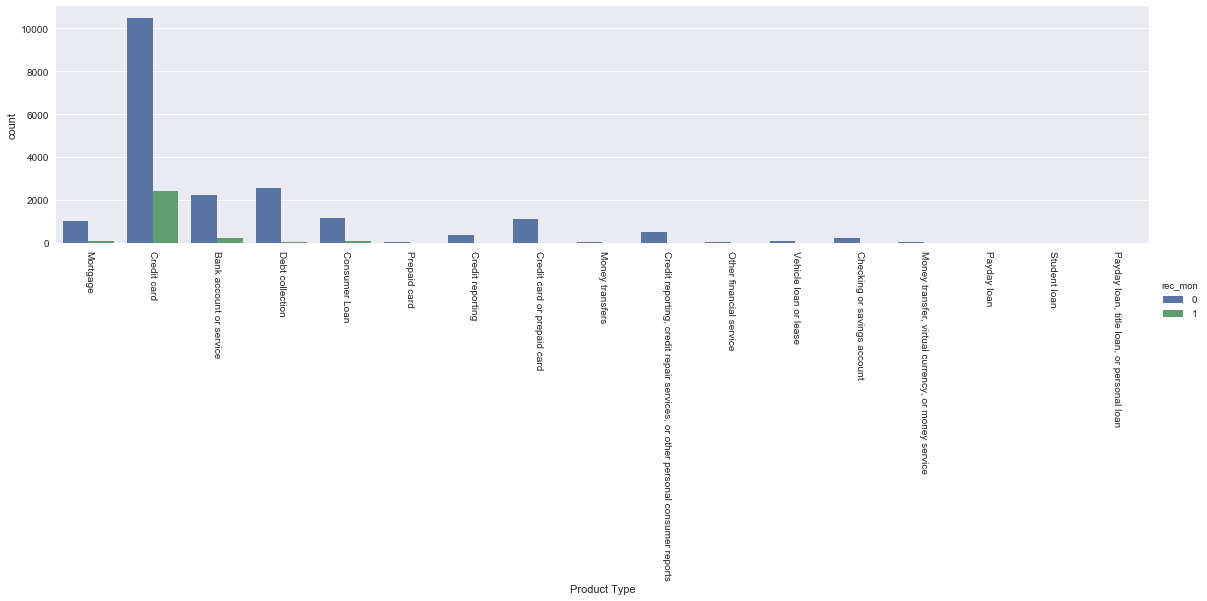

In [90]:
fg = sns.factorplot('Product', data=df, kind='count', aspect=4, hue="rec_mon")
fg.set_xlabels('Product Type')
fg.set_xticklabels(rotation=-90)

And let's also compare the groups of people who received monetary compensation vs. those who didn't across the original sentiment categories.

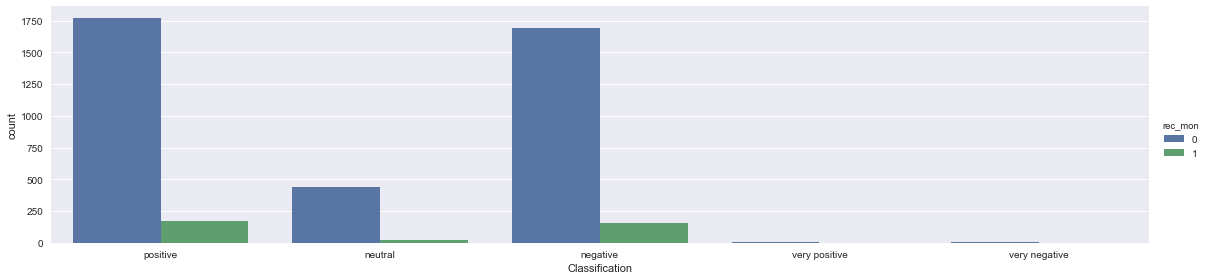

In [53]:
fg = sns.factorplot('cla', data=df, kind='count', aspect=4, hue="rec_mon")
fg.set_xlabels('Classification')

And let's also compare the groups of people who received monetary compensation vs. those who didn't across the modified sentiment categories.

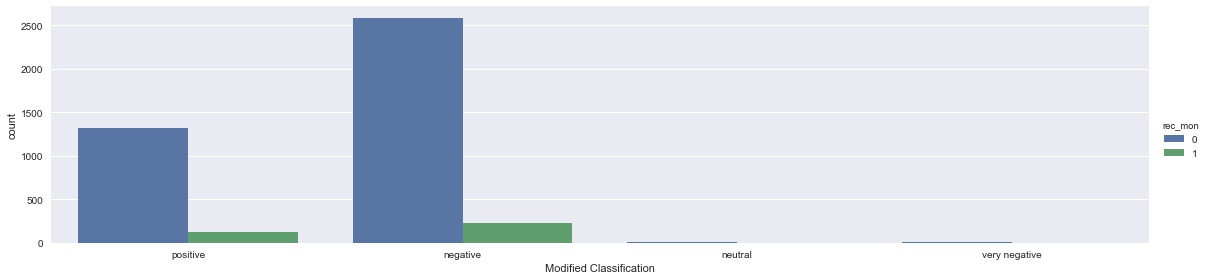

In [54]:
fg = sns.factorplot('mcla', data=df, kind='count', aspect=4, hue="rec_mon")
fg.set_xlabels('Modified Classification')

Compare customers who received monetary compensation vs. those who didn't by sentiment classification (original narratives).

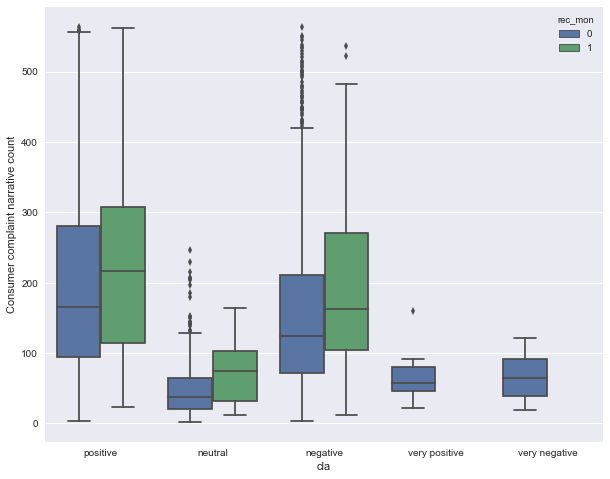

In [107]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]
plt.figure(figsize=(10, 8))

sns.boxplot(x="cla", y="Consumer complaint narrative count", hue="rec_mon", data=df_noout)

Compare customers who received monetary compensation vs. those who didn't by sentiment classification (modified narratives). We observe that complaints classified as positive or negative are more likely to receive monetary compensation. We also see that people who write longer narratives are more likely to receive compensation. That said, we would need to execute statistical analyses to ensure that the differences are statistically significant.

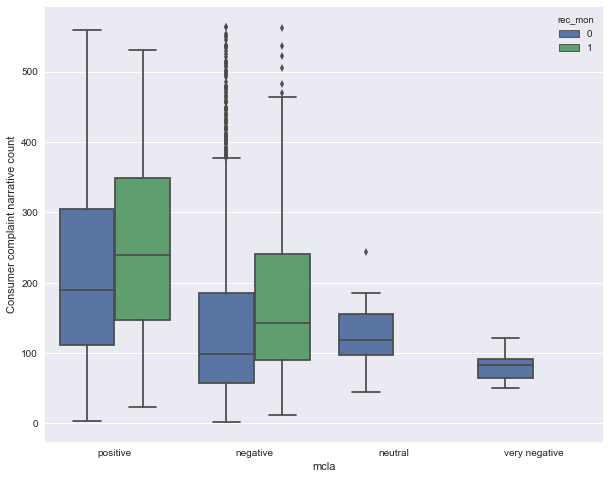

In [91]:
# Remove outliers
q = df["Consumer complaint narrative count"].quantile(0.99)
df_noout = df[df["Consumer complaint narrative count"] < q]
plt.figure(figsize=(10, 8))

sns.boxplot(x="mcla", y="Consumer complaint narrative count", hue="rec_mon", data=df_noout)


### Export dataframe to .csv

In [ ]:
# df.to_csv('c1complaints_mod1.csv')

# After this, import into ElasticSearch.

Outlier exclusion from # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe